In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from numpy.linalg import inv
from sklearn import metrics

In [2]:
skin = open('data.txt','r')
rl = skin.readlines()
#print(rl)

src_data = []
count = [0,0]
for e in rl:
    if(e.find('\n') != -1):
        e = e[:-1]
    a= e.split(' ')
    a = [float(i) for i in a]
    src_data.append(np.array(a))

skin.close()
#print(src_data)


train_1 = np.array([e[:-1] for e in src_data[:216] if e[-1] == 1])
train_2 = np.array([e[:-1] for e in src_data[:216] if e[-1] == 2])

test_1 = np.array([e[:-1] for e in src_data[216:] if e[-1] == 1])
test_2 = np.array([e[:-1] for e in src_data[216:] if e[-1] == 2])



In [3]:
def scatt(x):
    mean = np.mean(x, axis = 0)
    sct = x - mean
    Sct = np.dot(sct.T,sct)
    #print(Sct.shape)
    return Sct
def get_weights(cl_1, cl_2):
    Sw = scatt(cl_1) + scatt(cl_2)
    #print('Sw shape: ', Sw.shape)
    diff = np.mean(cl_1, axis = 0) - np.mean(cl_2, axis = 0)
    #print('Mean diff shape: ', diff.shape)
    W = np.dot( inv(Sw) , diff )
    #print('Weights shape: ', W.shape)
    return W
def project(W, cl_1,cl_2):
    Y_1 = np.dot(W.T,cl_1.T)
    Y_2 = np.dot(W.T,cl_2.T)
    return Y_1, Y_2

def find_threshold(y1,y2):
    mean1, mean2 = np.mean(y1), np.mean(y2)
    min_val = min(min(y1),min(y2))
    max_val = max(max(y1),max(y2))
    threshold = min_val
    y = np.concatenate((y1,y2),axis=0)
    best = 0
    while(threshold < max_val):
        correct = 0
        for e in y1:
            if(e >= threshold):
                correct+=1.0
        #print('Class 1 Acc', correct / (y1.shape[0]))
        
        for e in y2:
            if(e < threshold):
                correct+=1.0
        acc = correct / (y1.shape[0] + y2.shape[0])
        
        #print('Acc: ', acc)
        if(acc>best):
            best = acc
            #print(best)
            best_th = threshold
        threshold+=0.00001
    return best_th,best

def evaluate(y1,y2,threshold):
    correct = 0
    for e in y1:
        if(e >= threshold):
            correct+=1.0
    
    for e in y2:
        if(e < threshold):
            correct+=1.0
    
    acc = correct / (y1.shape[0] + y2.shape[0])
    return acc


def predict(y1,y2,threshold):  
    preds = []
    for e in y1:
        if(e >= threshold):
            preds.append(0.0)
        else:
            preds.append(1.0)
    
    for e in y2:
        if(e >= threshold):
            preds.append(0.0)
        else:
            preds.append(1.0)
        
        
    return np.array(preds)

In [4]:
#Get Weights
W = get_weights(train_1,train_2)

#Evaluate Train
Y_1, Y_2 = project(W,train_1,train_2)
threshold, best_acc = find_threshold(Y_1,Y_2)

#evaluate testing
ytest1, ytest2 = project(W,test_1,test_2)
acc = evaluate(ytest1, ytest2, threshold)

print('Threshold: ', threshold)
print('Training Accuracy: ' , best_acc)
print('Testing Accuracy: ', acc)

Threshold:  -0.03821124539215028
Training Accuracy:  0.8657407407407407
Testing Accuracy:  0.8888888888888888


In [5]:
preds = predict(ytest1,ytest2,threshold)
y_test = np.concatenate(( np.zeros((len(test_1))), np.ones( (len(test_2)) ) ), axis=0)

fpr, tpr, th = metrics.roc_curve(y_test, preds)

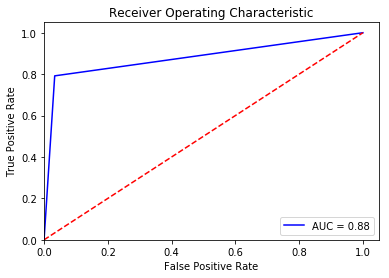

In [6]:
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()